# Synthetic Photometry

Synthetic photometry is the prediction of photometric observations (what you see in filters) from spectra, either observed or modeled.


 * https://synphot.readthedocs.io/en/latest/
 * https://learn.astropy.org/rst-tutorials/color-excess.html


In [1]:
import numpy as np
import glob
from astropy import table
from astropy.io import fits
from astropy import units as u
from astropy import constants
from astropy.utils.console import ProgressBar
from spectral_cube import lower_dimensional_structures
import requests
import tarfile
import os

In [2]:
%matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')

In [3]:
url = "http://specmodels.iag.usp.br/fits_search/compress/s_coelho14_sed.tgz"
fn = os.path.basename(url)
if not os.path.exists(fn):
    resp = requests.get(url)
    with open(fn, 'wb') as fh:
        fh.write(resp.content)

dir = os.path.splitext(fn)[0]
if not os.path.exists(dir):
    with tarfile.open(fn) as tf:
        tf.extractall()

In [4]:
from astroquery.svo_fps import SvoFps

In [5]:
Ucurve = SvoFps.get_transmission_data('Generic/Bessell.U')
Bcurve = SvoFps.get_transmission_data('Generic/Bessell.B')
Vcurve = SvoFps.get_transmission_data('Generic/Bessell.V')
Rcurve = SvoFps.get_transmission_data('Generic/Bessell.R')
Icurve = SvoFps.get_transmission_data('Generic/Bessell.I')

Text(0, 0.5, 'Transmission Fraction')

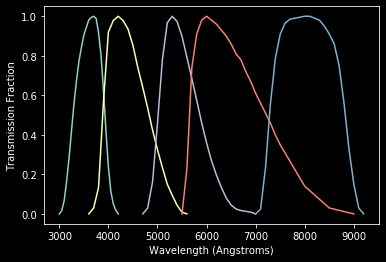

In [6]:
pl.plot(Ucurve['Wavelength'], Ucurve['Transmission'])
pl.plot(Bcurve['Wavelength'], Bcurve['Transmission'])
pl.plot(Vcurve['Wavelength'], Vcurve['Transmission'])
pl.plot(Rcurve['Wavelength'], Rcurve['Transmission'])
pl.plot(Icurve['Wavelength'], Icurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Transmission Fraction")

In [7]:
import specutils

In [8]:
spectrum = specutils.Spectrum1D.read('s_coelho14_sed/t04250_g+1.5_m10p04_sed.fits', format='wcs1d-fits')
wavelength = 10**spectrum.spectral_axis * u.AA
model_intensity = spectrum.data

Text(0, 0.5, 'Intensity (arbitrary)')

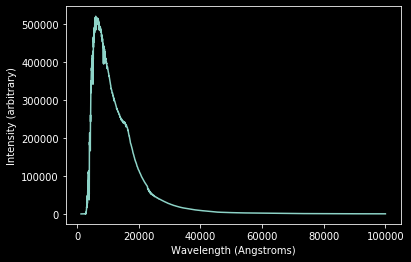

In [9]:
pl.plot(wavelength, model_intensity)
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (arbitrary)")

(3000, 9000)

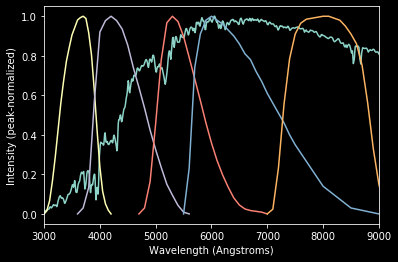

In [10]:
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(Ucurve['Wavelength'], Ucurve['Transmission'])
pl.plot(Bcurve['Wavelength'], Bcurve['Transmission'])
pl.plot(Vcurve['Wavelength'], Vcurve['Transmission'])
pl.plot(Rcurve['Wavelength'], Rcurve['Transmission'])
pl.plot(Icurve['Wavelength'], Icurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(3000,9000)

In [11]:
# interpolate transmission curve onto model grid
trans_int_I = np.interp(wavelength, Icurve['Wavelength'], Icurve['Transmission'])

(6500, 9500)

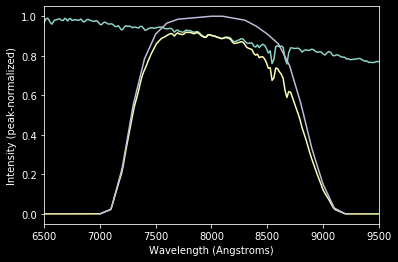

In [12]:
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(wavelength, model_intensity / model_intensity.max() * trans_int_I)
pl.plot(Icurve['Wavelength'], Icurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(6500,9500)

(5200, 8500)

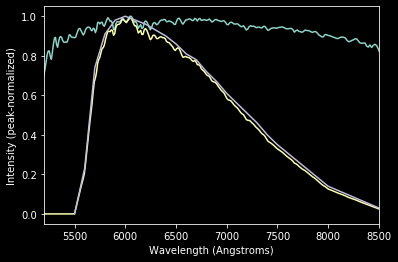

In [13]:
trans_int_R = np.interp(wavelength, Rcurve['Wavelength'], Rcurve['Transmission'])
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(wavelength, model_intensity / model_intensity.max() * trans_int_R)
pl.plot(Rcurve['Wavelength'], Rcurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(5200,8500)

(4500, 7000)

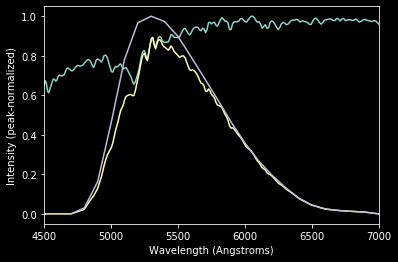

In [14]:
trans_int_V = np.interp(wavelength, Vcurve['Wavelength'], Vcurve['Transmission'])
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(wavelength, model_intensity / model_intensity.max() * trans_int_V)
pl.plot(Vcurve['Wavelength'], Vcurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(4500,7000)

(3500, 5000)

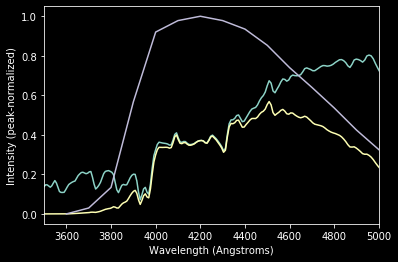

In [15]:
trans_int_B = np.interp(wavelength, Bcurve['Wavelength'], Bcurve['Transmission'])
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(wavelength, model_intensity / model_intensity.max() * trans_int_B)
pl.plot(Bcurve['Wavelength'], Bcurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(3500,5000)

(3000, 4000)

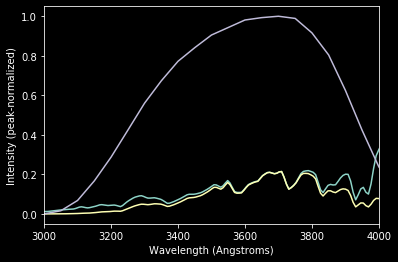

In [16]:
trans_int_U = np.interp(wavelength, Ucurve['Wavelength'], Ucurve['Transmission'])
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(wavelength, model_intensity / model_intensity.max() * trans_int_U)
pl.plot(Ucurve['Wavelength'], Ucurve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(3000,4000)

In [18]:
filters = {'U': Ucurve,
           'B': Bcurve,
           'R': Rcurve,
           'V': Vcurve,
           'I': Icurve
          }

In [33]:
# synthetic photometry:
star_relative_fluxes = {}
for filtername,tbl in filters.items():
    trans_int = np.interp(wavelength, tbl['Wavelength'], tbl['Transmission'])
    # take the integral (need to accout for different pixel sizes)
    filter_integral = (model_intensity[:-1] * trans_int[:-1] * (wavelength[1:] - wavelength[:-1]).quantity).sum()
    star_relative_fluxes[filtername] = filter_integral
star_relative_fluxes

{'U': <Quantity 47005519.82605141 Angstrom>,
 'B': <Quantity 2.51801066e+08 Angstrom>,
 'R': <Quantity 7.96741576e+08 Angstrom>,
 'V': <Quantity 4.06174027e+08 Angstrom>,
 'I': <Quantity 6.93352855e+08 Angstrom>}

In [41]:
ha_curve = SvoFps.get_transmission_data('KPNO/Mosaic.Halpha')

(6000, 7000)

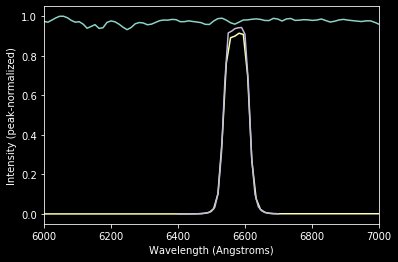

In [43]:
trans_int_ha = np.interp(wavelength, ha_curve['Wavelength'], ha_curve['Transmission'])
pl.plot(wavelength, model_intensity / model_intensity.max())
pl.plot(wavelength, model_intensity / model_intensity.max() * trans_int_ha)
pl.plot(ha_curve['Wavelength'], ha_curve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.xlim(6000,7000)

In [47]:
# hot star
hs_spectrum = specutils.Spectrum1D.read('s_coelho14_sed/t10000_g+4.0_m03p04_sed.fits', format='wcs1d-fits')
hs_wavelength = 10**hs_spectrum.spectral_axis * u.AA
hs_model_intensity = hs_spectrum.data

(3000, 9000)

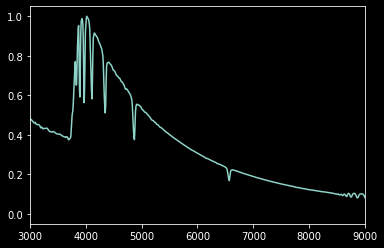

In [54]:
pl.plot(hs_wavelength, hs_model_intensity / hs_model_intensity.max())
pl.xlim(3000, 9000)

(6350, 6750, 0, 0.35)

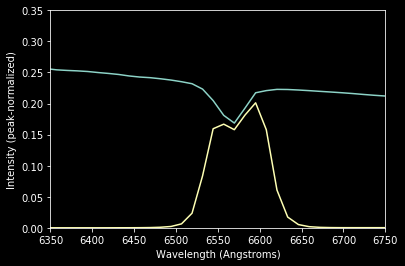

In [52]:
trans_int_ha = np.interp(hs_wavelength, ha_curve['Wavelength'], ha_curve['Transmission'])
pl.plot(hs_wavelength, hs_model_intensity / hs_model_intensity.max())
pl.plot(hs_wavelength, hs_model_intensity / hs_model_intensity.max() * trans_int_ha)
#pl.plot(ha_curve['Wavelength'], ha_curve['Transmission'])
pl.xlabel("Wavelength (Angstroms)")
pl.ylabel("Intensity (peak-normalized)")
pl.axis((6350,6750,0,0.35))